# No Batch but Channel

Coded by Lujia Zhong @lujiazho

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from miniml.ann import *
from miniml.ann.common import *
from miniml.ann.utils import *

In [2]:
train = pd.read_csv('./datasets/digit-recognizer/train.csv')
training_data = pd.read_csv('./datasets/digit-recognizer/train.csv')

train_label = train['label']
train = train.drop(['label'], axis=1)

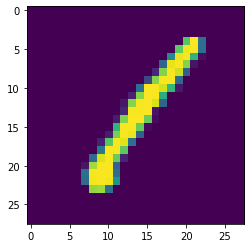

In [3]:
img = np.array(train.iloc[0]).reshape(28, 28)
_ = plt.imshow(img)

In [4]:
class Conv2D(Node):
    def __init__(self, nodes, weights, bias, output_c, input_c, stride=1, padding=False):
        self.output_c = output_c
        self.input_c = input_c
        self.stride = stride
        self.padding = padding
        self.bias = True if bias else False
        Node.__init__(self, [nodes, weights, bias] if bias else [nodes, weights])

    def conv_(self, n_c, n_h, n_w, img, filter_, s=1):
        k = filter_.shape[2]
        res = np.zeros((n_c, n_h, n_w))
        for i in range(n_h):
            for j in range(n_w):
                res[:,i,j] = np.sum(img[:,i*s:i*s+k,j*s:j*s+k]*filter_, axis=(1,2,3))
        return res
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        if self.bias:
            bias = self.inputs[2].value
        ks = weights.shape[2]  # kernel size (w equals to h)

        s = self.stride
        if self.padding:
            inputs = np.pad(inputs, ((0,0),(ks//2, ks//2),(ks//2, ks//2)), 'constant')
        assert (inputs.shape[1]-ks)%s == 0
        assert (inputs.shape[2]-ks)%s == 0
        assert s < ks

        n_c = self.output_c
        new_h = (inputs.shape[1]-ks)//s+1
        new_w = (inputs.shape[2]-ks)//s+1

        self.value = self.conv_(n_c, new_h, new_w, inputs, weights, s=s) + (bias if self.bias else 0)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = self.stride
        k = self.inputs[1].value.shape[2]
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            
            if s > 1:                
                tmp = np.insert(grad_cost.reshape(len(grad_cost),-1,1), 1, [[[0]]]*(s-1), axis=2)
                tmp = tmp.reshape(len(grad_cost),grad_cost.shape[1], -1)[:,:,:-(s-1)]
                tmp = np.insert(tmp, np.repeat(range(1,len(tmp[0])), (s-1)), [0]*tmp.shape[2], axis=1)
                inser_grad = np.pad(tmp, ((0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            else:
                inser_grad = np.pad(grad_cost, ((0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            
            # kernel: (q,p,h,w), rotate 2 times in h and w dimension
            rotated_w = np.rot90(self.inputs[1].value, 2, axes=(2,3))
            
            # X: (p,h,w)
            n_h = self.gradients[self.inputs[0]].shape[1]
            n_w = self.gradients[self.inputs[0]].shape[2]
            # self.gradients[self.inputs[0]] += self.conv_(n_h, n_w, inser_grad, rotated_w, s=1)
            aug1 = np.repeat(inser_grad, rotated_w.shape[1], axis=0)
            aug1 = aug1.reshape(len(inser_grad), rotated_w.shape[1], inser_grad.shape[1], inser_grad.shape[2])
            aug2 = np.repeat(rotated_w, len(aug1), axis=0)
            aug2 = aug2.reshape(len(rotated_w), aug1.shape[0], 
                                rotated_w.shape[1], rotated_w.shape[2], rotated_w.shape[3])

            grad_X = np.zeros_like(X, dtype=np.float64)
            shift = k//2 if self.padding else 0
            for i in range(n_h):
                for j in range(n_w):
                    grad_X[:,i,j] = np.sum(aug1[:,:,i+shift:i+shift+k,j+shift:j+shift+k]*aug2, axis=(0,1,3,4))
            self.gradients[self.inputs[0]] += grad_X
            
            # W: (q,p,h,w)
            aug1 = np.repeat(inser_grad, X.shape[0], axis=0)
            aug1 = aug1.reshape(len(inser_grad), X.shape[0], inser_grad.shape[1], inser_grad.shape[2])
            grad_W = np.zeros_like(self.inputs[1].value, dtype=np.float64)
            
            for i in range(grad_W.shape[2]):
                for j in range(grad_W.shape[3]):
                    grad_W[:,:,i,j] = np.sum(aug1[:,:,i:i+X.shape[1],j:j+X.shape[2]]*X, axis=(2,3))
            self.gradients[self.inputs[1]] += np.rot90(grad_W, 2, axes=(2,3))
            
            if self.bias:
                self.gradients[self.inputs[2]] += np.sum(grad_cost, axis=(1,2), keepdims=True)

In [5]:
class AvePooling(Node):
    def __init__(self, nodes, k=3):
        self.k = k
        Node.__init__(self, [nodes])

    def conv_(self, n_c, n_h, n_w, img, filter_, s=1):
        k = self.k
        res = np.zeros((n_c, n_h, n_w))
        for i in range(n_h):
            for j in range(n_w):
                res[:,i,j] = np.sum(img[:,i*s:i*s+k,j*s:j*s+k]*filter_, axis=(1,2))
        return res
        
    def forward(self):
        inputs = self.inputs[0].value
        k = self.k
        
        assert inputs.shape[1]%k == 0
        assert inputs.shape[2]%k == 0
        assert k > 1

        filter_ = np.ones((k, k))/(k*k)
        new_h = inputs.shape[1]//k
        new_w = inputs.shape[2]//k
        
        self.value = self.conv_(inputs.shape[0], new_h, new_w, inputs, filter_, s=k)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = k = self.k
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]

            tmp = np.insert(grad_cost.reshape(len(grad_cost),-1,1), 1, [[[0]]]*(s-1), axis=2)
            tmp = tmp.reshape(len(grad_cost),grad_cost.shape[1], -1)[:,:,:-(s-1)]
            tmp = np.insert(tmp, np.repeat(range(1,len(tmp[0])), (s-1)), [0]*tmp.shape[2], axis=1)
            inser_grad = np.pad(tmp, ((0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            
            w = np.ones((k, k))/(k*k)
            
            n_h = self.gradients[self.inputs[0]].shape[1]
            n_w = self.gradients[self.inputs[0]].shape[2]
            self.gradients[self.inputs[0]] += self.conv_(X.shape[0], n_h, n_w, inser_grad, w, s=1)

In [6]:
class Flatten(Node):
    def __init__(self, nodes):
        Node.__init__(self, [nodes])
        
    def forward(self):
        inputs = self.inputs[0].value
        self.value = inputs.flatten().reshape(1,-1)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] += grad_cost.reshape(X.shape)

In [7]:
W1 = np.random.randn(3, 1, 5, 5)
b1 = np.random.randn(3, 1, 1)

W2 = np.random.randn(10, 3, 3, 3)
b2 = np.random.randn(10, 1, 1)

W3 = np.random.randn(250, 100)
b3 = np.random.randn(100)

W4 = np.random.randn(100, 10)

x_node, y_node = Placeholder(), Placeholder()

W1_node = Placeholder()
b1_node = Placeholder()

W2_node = Placeholder()
b2_node = Placeholder()

W3_node = Placeholder()
b3_node = Placeholder()

W4_node = Placeholder()

conv1 = Conv2D(x_node, W1_node, b1_node, output_c=3, input_c=1, stride=1, padding=False)
ave1 = AvePooling(conv1, k=2)
conv2 = Conv2D(ave1, W2_node, b2_node, output_c=10, input_c=3, stride=1, padding=False)
ave2 = AvePooling(conv2, k=2)
flat = Flatten(ave2)
l1 = Linear(flat, W3_node, b3_node)
tanh1 = Sigmoid(l1)
l2 = Linear(tanh1, W4_node, None)
tanh2 = Sigmoid(l2)
mse = MSE(y_node, tanh2)

In [8]:
feed_dict = {
    x_node: np.array([img]),
    y_node: np.array([0,1,0,0,0,0,0,0,0,0]),

    W1_node: W1,
    b1_node: b1,

    W2_node: W2,
    b2_node: b2,
    
    W3_node: W3,
    b3_node: b3,
    
    W4_node: W4
}

graph = feed_dict_2_graph(feed_dict)    # network graph
sorted_graph = topology(graph)          # sorted graph
trainables = [W1_node, b1_node, W2_node, b2_node, W3_node, b3_node, W4_node]

In [9]:
optimizer = 'Adam'
lr=1e-2
epochs=20

# only used for Adam
it = 0

for i in range(1, epochs+1):
    it += 1
    losses = []
    for j in range(1000):
        # Step 4.1: sample a batch of examples and Reset value
        x_node.value = np.array(train.iloc[j]).reshape(1, 28, 28)
        y_node.value = np.eye(10)[train_label[j]].reshape(1,-1)

        # Step 4.2: forward
        for n in sorted_graph:
            n.forward()

        # Step 4.3: backward
        for n in sorted_graph[::-1]:
            n.backward()

        # Step 4.4: optimization
        for t in trainables:
            t.optimize(optimizer=optimizer, lr=lr, it=it)

        # Step 5: update current loss
        loss = sorted_graph[-1].value
        
        losses.append(loss)

    if i % 1 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, np.mean(losses)))

Epoch: 1, Loss: 0.1000
Epoch: 2, Loss: 0.0890
Epoch: 3, Loss: 0.0832
Epoch: 4, Loss: 0.0781
Epoch: 5, Loss: 0.0737
Epoch: 6, Loss: 0.0711
Epoch: 7, Loss: 0.0682
Epoch: 8, Loss: 0.0668
Epoch: 9, Loss: 0.0660
Epoch: 10, Loss: 0.0655
Epoch: 11, Loss: 0.0622
Epoch: 12, Loss: 0.0581
Epoch: 13, Loss: 0.0596
Epoch: 14, Loss: 0.0623
Epoch: 15, Loss: 0.0612
Epoch: 16, Loss: 0.0640
Epoch: 17, Loss: 0.0709
Epoch: 18, Loss: 0.0659
Epoch: 19, Loss: 0.0616
Epoch: 20, Loss: 0.0620


In [10]:
preds = []
reals = []
for i in range(1000):
    x_node.value = np.array(train.iloc[i]).reshape(1, 28, 28)
    for n in sorted_graph[:-1]:
        n.forward()
    preds.append(np.argmax(sorted_graph[-2].value))
    reals.append(train_label[i])
print(np.sum(np.array(preds)==np.array(reals))/1000)

0.577


In [11]:
for i in range(10):
    x_node.value = np.array(train.iloc[i]).reshape(1, 28, 28)
    for n in sorted_graph[:-1]:
        n.forward()
    print(f"pred: {np.argmax(sorted_graph[-2].value)}, real: {train_label[i]}")

pred: 8, real: 1
pred: 0, real: 0
pred: 1, real: 1
pred: 6, real: 4
pred: 0, real: 0
pred: 0, real: 0
pred: 7, real: 7
pred: 3, real: 3
pred: 5, real: 5
pred: 3, real: 3


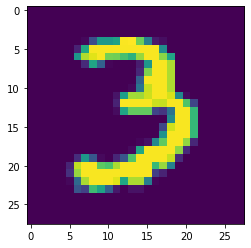

In [12]:
plt.imshow(x_node.value[0])

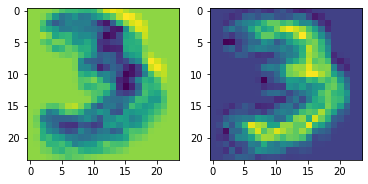

In [13]:
plt.subplot(121)
plt.imshow(conv1.value[0])
plt.subplot(122)
plt.imshow(conv1.value[1])
plt.show()

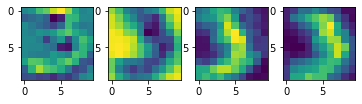

In [14]:
plt.subplot(141)
plt.imshow(conv2.value[0])
plt.subplot(142)
plt.imshow(conv2.value[1])
plt.subplot(143)
plt.imshow(conv2.value[2])
plt.subplot(144)
plt.imshow(conv2.value[3])
plt.show()